In [2]:
# Imports necessary libraries for API calls, data handling, time, and machine learning
import requests
import pandas as pd
import numpy as np
import pytz
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error

API_KEY = "dca885a7f61210902aaea785372a6d41"
BASE_URL = "https://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&units=metric"

In [3]:

# ==============================================================================
# SECTION 2: API and Data Loading Functions
# ==============================================================================

def get_current_weather(city):
    """Fetches current weather data for a specific city using the OpenWeatherMap API."""
    url = BASE_URL.format(city=city, API_KEY=API_KEY)
    
    # Send GET request and check for errors
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
    except requests.exceptions.HTTPError as e:
        print(f"Error fetching weather data: {e}")
        return None
    
    # Return relevant weather information
    return {
        "city_name": data.get("name"),
        "current_temp": round(data["main"]["temp"]),
        "feels_like": round(data["main"]["feels_like"]),
        "temp_min": round(data["main"]["temp_min"]),
        "temp_max": round(data["main"]["temp_max"]),
        "humidity": round(data["main"]["humidity"]),
        "description": data["weather"][0]["description"],
        "country": data["sys"]["country"],
        "pressure": data["main"]["pressure"],
        # Wind degree is used for direction mapping
        "wind_gust_deg": data["wind"]["deg"],
        # Wind speed is used as a feature
        "wind_gust_speed": data["wind"]["speed"]
    }


In [4]:
# Sample Current Weather INFO
city = input("Enter the City name to see its Current Weather INFO: ")
# display(get_current_weather("Phnom Penh")) #sample
display(get_current_weather(city.capitalize()))

{'city_name': 'New York',
 'current_temp': 7,
 'feels_like': 5,
 'temp_min': 4,
 'temp_max': 8,
 'humidity': 70,
 'description': 'overcast clouds',
 'country': 'US',
 'pressure': 1019,
 'wind_gust_deg': 170,
 'wind_gust_speed': 2.06}

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import requests 
from requests.exceptions import HTTPError, RequestException # Import specific exception types
API_KEY = "dca885a7f61210902aaea785372a6d41" 
BASE_URL = "https://api.openweathermap.org/data/2.5/weather"


class WeatherDashboard:
    """
    A class to fetch, process, and visualize current weather data for a city 
    using a dashboard layout created with Matplotlib.
    """
    
    def __init__(self):
        """Initializes the dashboard, data will be loaded upon running run_dashboard."""
        self.data = None

    # --- Utility Methods (Data Transformation and Fetching) ---

    def _map_internal_data(self, data_dict):
        """
        Ensures the data is in the final internal plotting format, applies rounding,
        and converts wind speed from m/s to km/h if it hasn't been done already.
        """
        try:
            speed = data_dict['wind_gust_speed']
            # Heuristic check: if the speed is low, it's likely m/s and needs conversion
            if speed < 10: 
                 data_dict['wind_gust_speed'] = round(speed * 3.6, 2)
            
            # Apply rounding as per user's original function output
            data_dict['current_temp'] = round(data_dict['current_temp'])
            data_dict['feels_like'] = round(data_dict['feels_like'])
            data_dict['temp_min'] = round(data_dict['temp_min'])
            data_dict['temp_max'] = round(data_dict['temp_max'])
            data_dict['humidity'] = round(data_dict['humidity'])
            data_dict['pressure'] = int(data_dict['pressure'])
            
            return data_dict

        except (KeyError, TypeError, IndexError) as e:
            print(f"ERROR: Failed to map pre-fetched data due to missing keys or invalid structure: {e}")
            return None


    def _get_city_weather_data(self, city):
        """
        Fetches current weather data for a specific city using the OpenWeatherMap API,
        using the correct requests method and matching the user's data processing.
        """
        print(f"INFO: Attempting to fetch data for {city} from API...")
        
        
        try:
            # 1. Prepare API request parameters (Correct use of requests.get)
            params = {
                'q': city,
                'appid': API_KEY,
                'units': 'metric' # Fetch temperatures in Celsius
            }
            
            # 2. Execute API request
            response = requests.get(BASE_URL, params=params)
            response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
            data = response.json()
        
            # 3. Extract data, matching the structure of the user's working function
            raw_output = {
                "city_name": data.get("name"),
                "current_temp": data["main"]["temp"],
                "feels_like": data["main"]["feels_like"],
                "temp_min": data["main"]["temp_min"],
                "temp_max": data["main"]["temp_max"],
                "humidity": data["main"]["humidity"],
                "description": data["weather"][0]["description"],
                "country": data["sys"]["country"],
                "pressure": data["main"]["pressure"],
                "wind_gust_deg": data["wind"].get("deg", 0),
                "wind_gust_speed": data["wind"]["speed"] # Speed is in m/s (needs conversion)
            }
            
            # 4. Final mapping and conversion (m/s to km/h, rounding)
            return self._map_internal_data(raw_output)

        except HTTPError as e:
            if e.response.status_code == 404:
                print(f"ERROR: City '{city}' not found (HTTP 404).")
            elif e.response.status_code == 401:
                print("ERROR 401: Unauthorized. Please check that your API key is correct and active.")
            else:
                print(f"ERROR: HTTP request failed: {e}")
            return None
        except RequestException as e:
            print(f"ERROR: Network or connection error: {e}")
            return None
        except Exception as e:
             print(f"An unexpected error occurred during data processing: {e}")
             return None

    def _degrees_to_cardinal(self, d):
        """Converts degree value (0-360) to 16-point cardinal direction."""
        dirs = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE",
                "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
        ix = round(d / (360. / len(dirs)))
        return dirs[ix % len(dirs)]

    # --- Visualization Methods (Subplots) ---

    def _plot_current_status(self, ax):
        ax.axis('off')
        city_country = f"{self.data['city_name']}, {self.data['country']}"
        current_status = f"{self.data['current_temp']}°C | {self.data['description'].title()}"
        ax.text(0.5, 0.85, city_country, fontsize=20, fontweight='bold', ha='center', transform=ax.transAxes)
        ax.text(0.5, 0.3, current_status, fontsize=36, color='#D0021B', ha='center', transform=ax.transAxes)

    def _plot_temperature_bars(self, ax):
        temps = [self.data['temp_min'], self.data['temp_max'], self.data['feels_like']]
        labels = ['Min Temp', 'Max Temp', 'Feels Like']
        colors = ['#4A90E2', '#D0021B', '#F5A623']
        bars = ax.bar(labels, temps, color=colors)
        ax.set_title('Temperature Details (°C)', fontsize=14)
        ax.set_ylabel('Temperature (°C)')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}°C', ha='center', va='bottom', fontsize=10)
        ax.set_ylim(min(temps)-5, max(temps)+5)

    def _plot_humidity_pressure(self, ax):
        ax.axis('off')
        ax.text(0.1, 0.7, 'HUMIDITY', fontsize=14, fontweight='bold', color='#4A90E2', transform=ax.transAxes)
        ax.text(0.1, 0.35, f"{self.data['humidity']} %", fontsize=30, ha='left', transform=ax.transAxes)
        ax.text(0.6, 0.7, 'PRESSURE', fontsize=14, fontweight='bold', color='#6AA84F', transform=ax.transAxes)
        ax.text(0.6, 0.35, f"{self.data['pressure']} hPa", fontsize=30, ha='left', transform=ax.transAxes)

    def _plot_wind_status(self, ax):
        ax.axis('off')
        wind_deg = self.data['wind_gust_deg']
        wind_dir = self._degrees_to_cardinal(wind_deg)
        
        ax.text(0.5, 0.75, 'WIND STATUS', fontsize=14, fontweight='bold', ha='center', transform=ax.transAxes)
        ax.text(0.5, 0.55, f"Direction: {wind_dir}", fontsize=20, ha='center', transform=ax.transAxes)
        ax.text(0.5, 0.35, f"Speed: {self.data['wind_gust_speed']} km/h", fontsize=20, ha='center', transform=ax.transAxes)
        
        angle_rad = np.deg2rad(90 - wind_deg)
        arrow_length = 0.2
        arrow_end_x = arrow_length * np.cos(angle_rad)
        arrow_end_y = arrow_length * np.sin(angle_rad)
        start_x, start_y = 0.5, 0.1 
        
    # --- Main Execution Methods ---

    def render_dashboard(self):
        """Generates and displays the complete Matplotlib dashboard."""
        if not self.data:
            print("ERROR: Cannot render dashboard. Data is missing. Run run_dashboard() first.")
            return

        fig = plt.figure(figsize=(10, 8))
        fig.suptitle('Current Weather Dashboard', fontsize=24, fontweight='bold')
        
        gs = GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.1)
        
        self._plot_current_status(fig.add_subplot(gs[0, :]))
        self._plot_temperature_bars(fig.add_subplot(gs[1, 0]))
        self._plot_humidity_pressure(fig.add_subplot(gs[1, 1]))
        self._plot_wind_status(fig.add_subplot(gs[2, :]))
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def run_dashboard(self, data_source):
        """
        Fetches or accepts data, then renders the dashboard.
        
        :param data_source: Can be a string (city name) or a dictionary 
                            containing the pre-fetched processed data.
        """
        data_to_process = None

        if isinstance(data_source, str):
            # User provided a city name, fetch via API
            data_to_process = self._get_city_weather_data(data_source)
        elif isinstance(data_source, dict):
            # User provided pre-fetched data (must be in the internal format)
            print("INFO: Processing pre-fetched data...")
            data_to_process = self._map_internal_data(data_source)
        else:
            print("ERROR: Invalid input for run_dashboard. Must be a city name (str) or a data dictionary (dict).")
            return
            
        if data_to_process:
            self.data = data_to_process
            self.render_dashboard()
        else:
            print(f"Failed to load or display weather data. Check input data or city name.")

INFO: Attempting to fetch data for Phnom penh from API...


/var/folders/h_/n_hvysld07s80ry_ldjph_pm0000gn/T/ipykernel_97337/1289404844.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


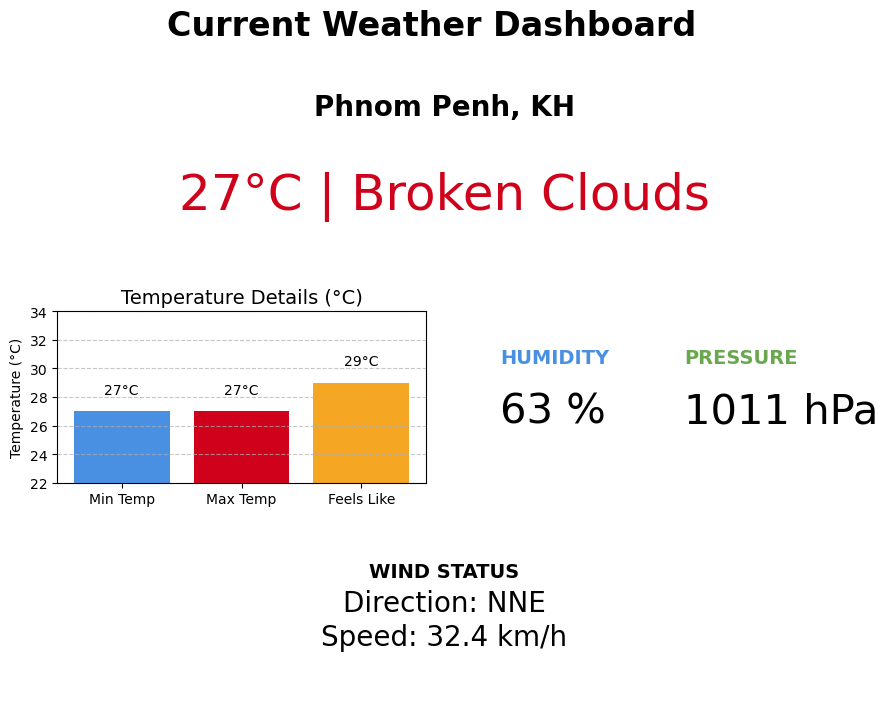

In [ ]:
# Test visualization
city = input("Enter a city where You want to see its weather: ")
dashboard = WeatherDashboard()
# dashboard.run_dashboard("Phnom Penh")
dashboard.run_dashboard(city.capitalize())